# Pipeline for the anomaly detection on the SkAB using $\phi$ - combined $T^2$ Hotelling's and Q (SPE) statistics with the PCA

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../utils')
from t2 import T2
from evaluating import evaluating_change_point

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (1154, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 13241

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.770310,0.382638,71.2129,25.0827,219.789,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027269,0.040226,1.096960,0.710565,71.4284,25.0863,233.117,32.0104,0.0,0.0
2020-03-09 12:14:38,0.027040,0.039773,1.140150,0.054711,71.3468,25.0874,234.745,32.0000,0.0,0.0
2020-03-09 12:14:39,0.027563,0.040313,1.108680,-0.273216,71.3258,25.0897,205.254,32.0104,0.0,0.0
2020-03-09 12:14:41,0.026570,0.039566,0.704404,0.382638,71.2725,25.0831,212.095,33.0000,0.0,0.0


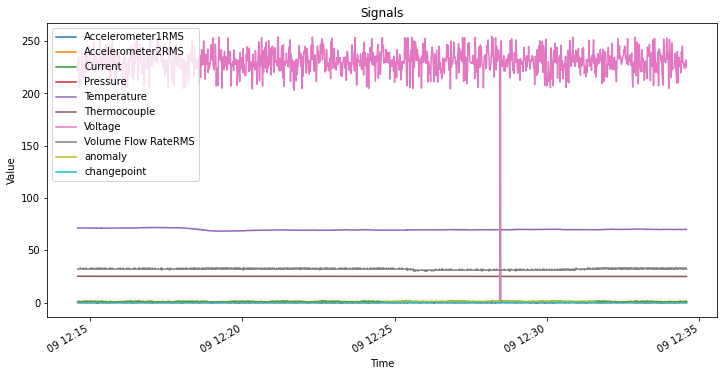

In [5]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

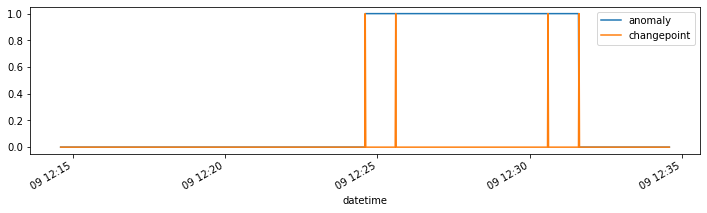

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [8]:
# classifier initializing
t2 = T2(scaling=True, using_PCA=True)

In [9]:
# train set selection
# X_train = anomaly_free_df
# X_train = list_of_df[0][:'2020-03-09 12:21'].drop(['anomaly','changepoint'], axis=1)

# classifier fitting
# t2.fit(X_train)

In [28]:
(((t2.T2>t2.T2_UCL)&(t2.Q>t2.Q_UCL)).astype(int))[0]

datetime
2020-03-09 12:14:36    0
2020-03-09 12:14:37    0
2020-03-09 12:14:38    0
2020-03-09 12:14:39    0
2020-03-09 12:14:41    0
                      ..
2020-03-09 12:34:31    1
2020-03-09 12:34:32    1
2020-03-09 12:34:33    0
2020-03-09 12:34:34    0
2020-03-09 12:34:35    0
Name: 0, Length: 1154, dtype: int64

In [30]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # classifier fitting
    t2.fit(X_train)
    
    t2.predict(df.drop(['anomaly','changepoint'], axis=1), window_size=5, plot_fig=False)
    prediction = pd.Series(((t2.T2>t2.T2_UCL)&(t2.Q>t2.Q_UCL)).astype(int)[0], 
                                index=df.index).fillna(0)
    
    predicted_outlier.append(prediction)
    
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

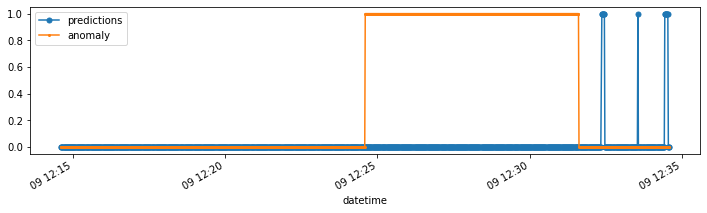

In [32]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

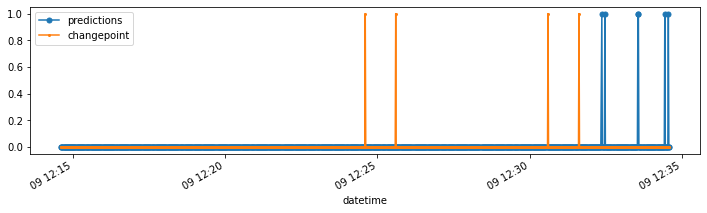

In [33]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [35]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 5.09 %
Missing Alarm Rate 86.1 %


In [36]:
# average detection delay metric calculation
# Missing values means a number of not detected changepoints
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:06.888888
Missing values: 121


In [37]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
Standart  -  5.83
LowFP  -  4.8
LowFN  -  6.19


## [Additional] localization